# TFM: Predicción de la demanda energética - Parte 5: Serie temporal de consumo total de un cliente (CU 3)
#### Lara Palacios

En este caso de uso, vamos a analizar la serie temporal del consumo total de un cliente.

## 0. Importación de librerías

In [1]:
!pip install skforecast

In [2]:
!pip install pmdarima

In [3]:
!pip install shap

In [4]:
!pip install prophet

In [5]:
import pandas as pd
import numpy as np
import json
import joblib
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
from io import StringIO
import contextlib
import re
import gc
import warnings
import time

from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.preprocessing import PolynomialFeatures
from sklearn.ensemble import RandomForestRegressor

from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller, kpss
from statsmodels.tsa.seasonal import seasonal_decompose

from skforecast.ForecasterBaseline import ForecasterEquivalentDate
from skforecast.ForecasterAutoreg import ForecasterAutoreg
from skforecast.ForecasterAutoregDirect import ForecasterAutoregDirect
from skforecast.model_selection import backtesting_forecaster, bayesian_search_forecaster, grid_search_forecaster
from skforecast.Sarimax import Sarimax
from skforecast.ForecasterSarimax import ForecasterSarimax
from skforecast.model_selection_sarimax import backtesting_sarimax, grid_search_sarimax

from pmdarima import ARIMA
from pmdarima import auto_arima

from lightgbm import LGBMRegressor
import plotly.graph_objects as go

import shap

from prophet import Prophet

pd.set_option('display.max_colwidth', None)
warnings.filterwarnings('ignore')

## 3. Preparación de los datos

En este cuaderno trabajaremos solo con la serie temporal de la variable CONSUMO:

In [6]:
variable = 'CONSUMO'

### 3.2. Integridad de la serie temporal

#### 3.2.0. Carga de los datos

In [7]:
#conexión a google drive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [8]:
df_preprocesado = pd.read_parquet('/content/drive/MyDrive/TFM/df_preprocesado_red.parquet')
df_preprocesado.shape

(15140750, 26)

In [9]:
seleccionar_clientes = pd.read_parquet('/content/drive/MyDrive/TFM/seleccionar_clientes.parquet')
seleccionar_clientes.shape

(11137, 4)

Añadiendo condiciones sobre el dataframe 'seleccionar_clientes' podemos descartar a clientes que no cumplan condiciones de integridad.

In [10]:
filtro_clientes = seleccionar_clientes[(seleccionar_clientes['FILAS_NA'] == 0) & (seleccionar_clientes['INICIO'] == seleccionar_clientes['INICIO'].min()) & (seleccionar_clientes['FIN'] == seleccionar_clientes['FIN'].max())].reset_index(drop = True)
filtro_clientes.shape

(1455, 4)

Seleccionamos, por ejemplo, al siguiente cliente:

In [11]:
df = df_preprocesado[df_preprocesado['PK_CLIENTE'] == 9551]
df.shape

(1440, 26)

In [12]:
#para liberar espacio de la RAM en Google Colab
del filtro_clientes
gc.collect()
filtro_clientes=pd.DataFrame()

In [13]:
#para liberar espacio de la RAM en Google Colab
del df_preprocesado
gc.collect()
df_preprocesado=pd.DataFrame()

#### 3.2.1. Formato de serie temporal

En este análsis las variables que son constantes a nivel de clientes no son relevantes, pues como no varían a lo largo del tiempo, no son predictivas. Además, establecemos como índice la columna DATETIME, lo cual nos facilitará la tarea a la hora de hacer futuras operaciones con ella.

In [14]:
df = df[['PK_CLIENTE', 'PK_ANYOMESDIA', 'PK_HORA', 'ORTO', 'OCASO', 'NIEVE', 'ESTADO_CIELO', 'DESCRIPCION', 'SENS_TERMICA', 'TEMPERATURA',
  'PRECIPITACION', 'HUMEDAD_RELATIVA', 'VIENTO_DIRECCION', 'VIENTO_VELOCIDAD', 'VIENTO_AND_RACHA_MAX', 'DATETIME', 'CONSUMO']]

In [15]:
df_consumo_total = df.set_index('DATETIME').asfreq('H')

In [16]:
#para liberar espacio de la RAM en Google Colab
del df
gc.collect()
df=pd.DataFrame()

Seleccionamos alguna variable más que luego nos servirá para añadir como variable exógena al modelo predictivo:

Comprobamos ahora que nuestra serie temporal está completa:

In [17]:
(df_consumo_total.index == pd.date_range(start=df_consumo_total.index.min(), end=df_consumo_total.index.max(), freq='H')).all()

True

In [18]:
print(f"Filas con valores ausentes: {df_consumo_total.isnull().any(axis=1).mean()}")

Filas con valores ausentes: 0.0


In [19]:
df_consumo_total = df_consumo_total.loc[df_consumo_total.index <= '2022-12-31 23:00:00']

#### 3.2.2. Variables exógenas

Podemos introducir otras variables de las cuáles podría depender también el consumo de un hogar, y que se incluyen típicamente en análisis de series temporales como son: el día de la semana y el indicador de si es fin de semana o no.
Las usaremos más adelante para cuando queramos incluir variables exógenas a nuestros modelos predictivos.

In [20]:
def minutos_a_formato_h(var_minutos):
    horas = int(var_minutos // 60)
    minutos = int(var_minutos % 60)
    var_formateada = f"{horas:02d}:{minutos:02d}"
    var_formateada = pd.to_datetime(var_formateada, format='%H:%M').hour
    return var_formateada

In [21]:
#variables de calendario
df_consumo_total['HORA'] = df_consumo_total.index.hour #+1
df_consumo_total['DIA_SEMANA'] = df_consumo_total.index.dayofweek #+1
df_consumo_total['FIN_DE_SEMANA'] = (df_consumo_total['DIA_SEMANA'] >= 5).astype(int)
#variables de luz solar
df_consumo_total['ORTO_minutos'] = df_consumo_total['ORTO'].apply(lambda x: int(x.split(':')[0]) * 60 + int(x.split(':')[1]))
df_consumo_total['OCASO_minutos'] = df_consumo_total['OCASO'].apply(lambda x: int(x.split(':')[0]) * 60 + int(x.split(':')[1]))
df_consumo_total['H_LUZ_SOLAR'] = (df_consumo_total['OCASO_minutos'] - df_consumo_total['ORTO_minutos'])
df_consumo_total['H_LUZ_SOLAR'] = df_consumo_total['H_LUZ_SOLAR'].apply(minutos_a_formato_h)
df_consumo_total['ORTO'] = df_consumo_total['ORTO_minutos'].apply(minutos_a_formato_h)
df_consumo_total['OCASO'] = df_consumo_total['OCASO_minutos'].apply(minutos_a_formato_h)
df_consumo_total["ES_DE_DIA"] = np.where((df_consumo_total.index.hour>df_consumo_total["ORTO"]) & (df_consumo_total.index.hour<df_consumo_total["OCASO"]),1,0)
df_consumo_total = df_consumo_total.drop(columns = ['OCASO_minutos', 'ORTO_minutos'])

In [22]:
df_consumo_total.head()

,PK_CLIENTE,PK_ANYOMESDIA,PK_HORA,ORTO,OCASO,NIEVE,ESTADO_CIELO,DESCRIPCION,SENS_TERMICA,TEMPERATURA,...,HUMEDAD_RELATIVA,VIENTO_DIRECCION,VIENTO_VELOCIDAD,VIENTO_AND_RACHA_MAX,CONSUMO,HORA,DIA_SEMANA,FIN_DE_SEMANA,H_LUZ_SOLAR,ES_DE_DIA
DATETIME,,,,,,,,,,,,,,,,,,,,,
2022-11-09 00:00:00,9551,2022-11-09,0,7,17,0.0,17n,Nubes altas,15.0,15.0,...,91,SE,10,17,27.0,0,2,0,10,0
2022-11-09 01:00:00,9551,2022-11-09,1,7,17,0.0,17n,Nubes altas,15.0,15.0,...,92,SE,9,13,23.0,1,2,0,10,0
2022-11-09 02:00:00,9551,2022-11-09,2,7,17,0.0,17n,Nubes altas,15.0,15.0,...,92,S,5,4,23.0,2,2,0,10,0
2022-11-09 03:00:00,9551,2022-11-09,3,7,17,0.0,17n,Nubes altas,14.0,14.0,...,92,SE,2,4,23.0,3,2,0,10,0
2022-11-09 04:00:00,9551,2022-11-09,4,7,17,0.0,17n,Nubes altas,14.0,14.0,...,92,SE,2,5,27.0,4,2,0,10,0


In [23]:
#Crear dataframe variables exógenas
exog_cols = ['TEMPERATURA', 'NIEVE', 'PRECIPITACION', 'HUMEDAD_RELATIVA', 'VIENTO_VELOCIDAD', 'VIENTO_AND_RACHA_MAX', 'FIN_DE_SEMANA', 'H_LUZ_SOLAR', 'ES_DE_DIA']

Una vez tenemos ya extraídas todas las variables exógenas que nos interesan, hagamos algunos pasos adicionales.

##### Variables con patrones cíclicos

Algunos aspectos del calendario, como las horas o los días, son cíclicos. Así, este tipo de variables pueden transformarse para captar la ciclicidad de estos datos, utilizando el seno y el coseno de su periodo, y evitar imponer un orden lineal.

In [24]:
def codificacion_ciclica(datos, longitud_ciclo): #Se asume que el valor mínimo de la variable es 0
    seno = np.sin(2 * np.pi * datos/longitud_ciclo)
    coseno = np.cos(2 * np.pi * datos/longitud_ciclo)
    resultado =  pd.DataFrame({f"{datos.name}_seno": seno, f"{datos.name}_coseno": coseno})
    return resultado

DIA_SEMANA_encoded = codificacion_ciclica(df_consumo_total['DIA_SEMANA'], longitud_ciclo=7)
HORA_encoded = codificacion_ciclica(df_consumo_total['HORA'], longitud_ciclo=24)
ORTO_encoded = codificacion_ciclica(df_consumo_total['ORTO'], longitud_ciclo=24)
OCASO_encoded = codificacion_ciclica(df_consumo_total['OCASO'], longitud_ciclo=24)
variables_ciclicas = pd.concat([DIA_SEMANA_encoded, HORA_encoded,ORTO_encoded,OCASO_encoded], axis=1)
df_consumo_total = pd.concat([df_consumo_total, variables_ciclicas], axis=1)

In [25]:
exog_cols.extend(df_consumo_total.filter(regex='_seno$|_coseno$').columns.tolist())

##### Interacción entre variables

En ocasiones, las variables exógenas no son independientes. Podemos capturar esta interacción mediante nuevas variables (que se obtienen multiplicando entre sí las variables existentes).

In [26]:
transformer_poly = PolynomialFeatures(degree = 2, interaction_only = True, include_bias = False).set_output(transform="pandas")
poly_cols = ['FIN_DE_SEMANA','DIA_SEMANA_seno','DIA_SEMANA_coseno','HORA_seno','HORA_coseno','H_LUZ_SOLAR','ES_DE_DIA','ORTO_seno','ORTO_coseno','OCASO_seno','OCASO_coseno']

variables_poly = transformer_poly.fit_transform(df_consumo_total[poly_cols].dropna()).drop(columns=poly_cols)
variables_poly.columns = [f"poly_{col}" for col in variables_poly.columns]
variables_poly.columns = variables_poly.columns.str.replace(" ", "__")
df_consumo_total = pd.concat([df_consumo_total, variables_poly], axis=1)

In [27]:
exog_cols.extend(df_consumo_total.filter(regex='^poly_.*').columns.tolist())

#### 3.2.3. Separación de los datos en conjuntos de train, validation y test

Para poder optimizar los hiperparámetros del modelo y evaluar su capacidad predictiva, se dividen los datos en 3 conjuntos, uno de entrenamiento, uno de validación y otro de test.

Notar que en el caso de series temporales no hay que aislar la variable target del resto, pues los valores pasados de esta variable se utilizan para su predicción.

In [28]:
df_consumo_total['DIA'] = df_consumo_total.index.date
dias = df_consumo_total['DIA'].unique()
n_dias = len(dias)

dias_train = int(n_dias * 0.6)
dias_validation = int(n_dias * 0.3)
dias_test = n_dias - dias_train - dias_validation

train_data = df_consumo_total[df_consumo_total['DIA'].isin(dias[:dias_train])]
validation_data = df_consumo_total[df_consumo_total['DIA'].isin(dias[dias_train:dias_train + dias_validation])]
test_data = df_consumo_total[df_consumo_total['DIA'].isin(dias[dias_train + dias_validation:])]

print("---Serie temporal del consumo total de la red de clientes---")
print(f"Fechas train      : {train_data.index.min()} --- {train_data.index.max()}  (n={len(train_data)})")
print(f"Fechas validacion : {validation_data.index.min()} --- {validation_data.index.max()}  (n={len(validation_data)})")
print(f"Fechas test       : {test_data.index.min()} --- {test_data.index.max()}  (n={len(test_data)})")

---Serie temporal del consumo total de la red de clientes---
Fechas train      : 2022-11-09 00:00:00 --- 2022-12-09 23:00:00  (n=744)
Fechas validacion : 2022-12-10 00:00:00 --- 2022-12-24 23:00:00  (n=360)
Fechas test       : 2022-12-25 00:00:00 --- 2022-12-31 23:00:00  (n=168)


In [29]:
#eliminar columna DIA

## 4. Exploración gráfica

### 4.1. Representación gráfica de la serie temporal
Con separación de datos de train, validación y test.

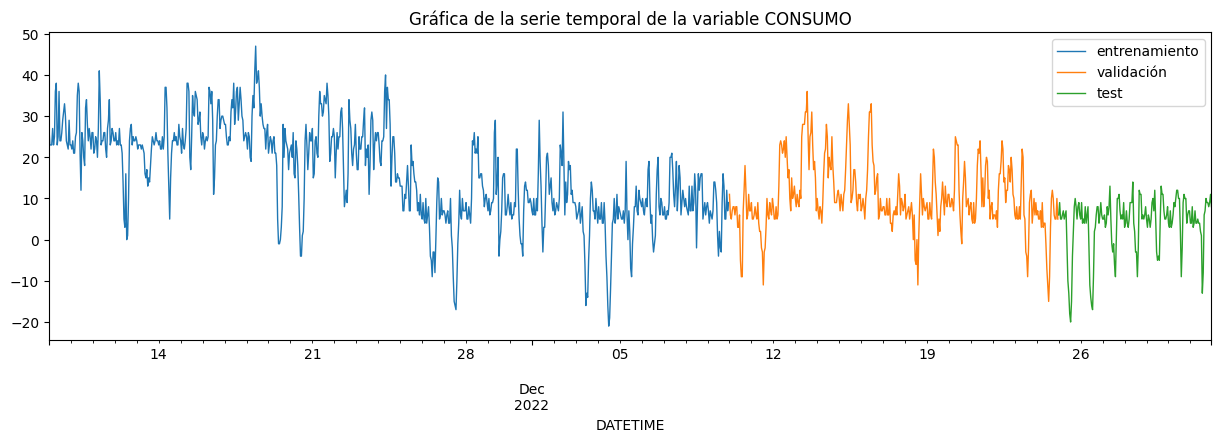

In [30]:
fig, ax = plt.subplots(figsize=(15, 4))
train_data[variable].plot(ax=ax, label= 'entrenamiento', linewidth=1)
validation_data[variable].plot(ax=ax, label= 'validación', linewidth=1)
test_data[variable].plot(ax=ax, label= 'test', linewidth=1)
ax.set_title(f'Gráfica de la serie temporal de la variable {variable}')
ax.legend()

### 4.2. Distribución de la carga por día de la semana

Text(0.5, 0.98, '')

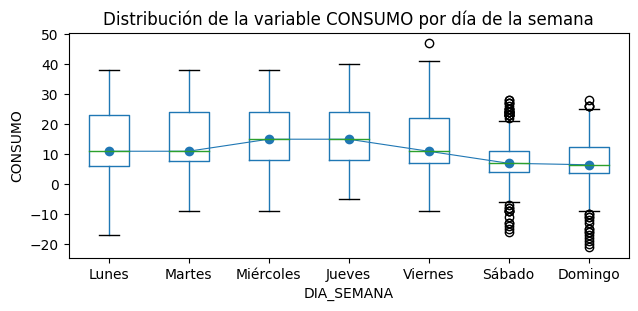

In [31]:
fig, ax = plt.subplots(figsize=(7, 3))
df_consumo_total.boxplot(column=variable, by='DIA_SEMANA', ax=ax, grid=False)
medianas = df_consumo_total.groupby('DIA_SEMANA')[variable].median()
medianas.index = medianas.index + 1
medianas.plot(style='o-', linewidth=0.8, ax=ax)
dias_semana = ['Lunes', 'Martes', 'Miércoles', 'Jueves', 'Viernes', 'Sábado', 'Domingo']
plt.xticks(ticks=range(1,8), labels=dias_semana)
ax.set_ylabel(variable)
ax.set_title(f'Distribución de la variable {variable} por día de la semana')
fig.suptitle('')

### 4.3. Distribución de la carga por hora del día

Text(0.5, 0.98, '')

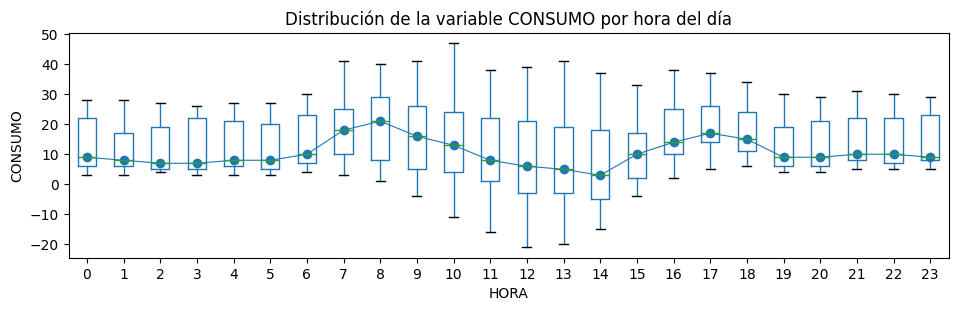

In [32]:
fig, ax = plt.subplots(figsize=(11, 3))
df_consumo_total['HORA'] = df_consumo_total.index.hour
df_consumo_total.boxplot(column=variable, by='HORA', ax=ax)
medianas = df_consumo_total.groupby('HORA')[variable].median()
medianas.index = medianas.index + 1
medianas.plot(style='o-', linewidth=0.8, ax=ax)
ax.set_ylabel(variable)
ax.set_title(f'Distribución de la variable {variable} por hora del día')
fig.suptitle('')

## 5. Creación y entrenamiento del modelo

### 5.0. Definición de funciones necesarias

In [33]:
train_val_data = pd.concat([train_data, validation_data], axis=0)

In [34]:
tabla_comparacion_modelos = pd.DataFrame(columns=['Modelo', 'Tiempo de ejecución', 'Variables exógenas', 'refit', 'MAE', 'MSE', 'RMSE'])

def guardar_results(modelo, tiempo, mae, mse, rmse, tabla_comparacion_modelos, var_exog = 'No', refit = 'No'):
  tabla_comparacion_modelos = pd.concat([tabla_comparacion_modelos, pd.DataFrame({'Modelo': modelo, 'Tiempo de ejecución': tiempo, 'Variables exógenas': var_exog, 'refit': refit, 'MAE': mae.round(1), 'MSE': mse.round(1), 'RMSE': rmse.round(1)}, index=[0])], ignore_index=True)
  return tabla_comparacion_modelos

In [35]:
def all_metrics(prediccion, test_data):
    metrics = {}
    metrics['MAE'] = mean_absolute_error(test_data[variable], prediccion)
    metrics['MSE'] = mean_squared_error(test_data[variable], prediccion)
    metrics['RMSE'] = np.sqrt(metrics['MSE'])
    return metrics

In [81]:
def backtesting(forecaster, df, train_data, test_data, grafica = True, refit = False, exog_cols = None):
    inicio = time.time()

    if exog_cols is not None:
        exog = df[exog_cols]
    else:
        exog = None
    if refit == False:
      fixed_train_size = True
    elif refit == True:
      fixed_train_size = False
    params = {
        'forecaster': forecaster,
        'y': df[variable],
        'exog': exog,
        'steps': 24,
        'metric': 'mean_absolute_error',
        'initial_train_size': len(df[variable].loc[:train_data.index.max()]),
        'n_jobs': 'auto',
        'verbose': False,
        'show_progress': True,
        'fixed_train_size': fixed_train_size,
        'refit': refit
    }
    if isinstance(forecaster, ForecasterSarimax):
        metric, predictions = backtesting_sarimax(**params)
    else:
        metric, predictions = backtesting_forecaster(**params)

    fin = time.time()
    tiempo = fin-inicio
    print(f"Tiempo de ejecución: {tiempo}")

    metrics = all_metrics(predictions, test_data)
    print(f"Métricas de error: {metrics}")

    if grafica == True:
      fig, ax = plt.subplots(figsize=(11, 3))
      train_data[variable].plot(ax=ax, label='train', color = '#1f77b4')
      # color para el de validación '#ff7f0e'
      test_data[variable].plot(ax=ax, label='test', color = '#2ca02c')
      predictions.plot(ax=ax, label='predicciones', color = '#FF0000')
      ax.set_title(f'Predicción sobre la variable {variable}')
      ax.legend()

    print("--------------------------------")
    return metrics, tiempo, predictions

In [37]:
def importancia_features(forecaster, df, train_data):
  forecaster.fit(y = df.loc[:train_data.index.max(), variable], exog = df.loc[:train_data.index.max(), exog_cols])
  feature_importances = forecaster.get_feature_importances()
  feature_importances['%_importance'] = ((feature_importances['importance'] / feature_importances['importance'].sum()) * 100).round(2)
  feature_importances = feature_importances.sort_values(by='%_importance', ascending=False).head(10).reset_index(drop = True).drop(columns = ['importance'])
  return feature_importances

In [38]:
def shap_values(forecaster, train_data):
  X_train, y_train = forecaster.create_train_X_y(y=train_val_data[variable]) # Matrices de entrenamiento utilizadas por el forecaster para entrenar el regresor

  params = forecaster.regressor.get_params()
  params['predict_disable_shape_check'] = True
  forecaster.regressor = LGBMRegressor(**params)
  forecaster.regressor.fit(X_train, y_train)

  explainer = shap.TreeExplainer(forecaster.regressor)
  # Se selecciona una muestra del 50% de los datos para acelerar el cálculo
  rng = np.random.default_rng(seed=785412)
  sample = rng.choice(X_train.index, size=int(len(X_train)*0.5), replace=False)
  X_train_sample = X_train.loc[sample, :]
  shap_values = explainer.shap_values(X_train_sample)

  shap.initjs()
  shap.summary_plot(shap_values, X_train_sample, max_display=10, show=False)
  fig, ax = plt.gcf(), plt.gca()
  ax.set_title("SHAP Summary plot")
  ax.tick_params(labelsize=8)
  fig.set_size_inches(6, 3.5)
  plt.show()

### 5.1. Baseline

La librería *Skforecast* facilita la creación de un baseline utilizando su clase *ForecasterEquivalentDate*. Este modelo simplemente devuelve el valor observado en el mismo período de la temporada anterior. En este caso, el modelo predice el valor del día siguiente utilizando el valor de la misma hora y del mismo día de la semana anterior.

Una vez entrenado el modelo, evaluaremos su capacidad predictiva mediante un proceso de backtesting.

In [42]:
params = {
    'offset': pd.DateOffset(days=7),
    'n_offsets': 1
}
baseline = ForecasterEquivalentDate(**params)

  0%|          | 0/7 [00:00<?, ?it/s]

Tiempo de ejecución: 0.2457587718963623
Métricas de error: {'MAE': 6.125, 'MSE': 70.82738095238095, 'RMSE': 8.41590048374985}
--------------------------------


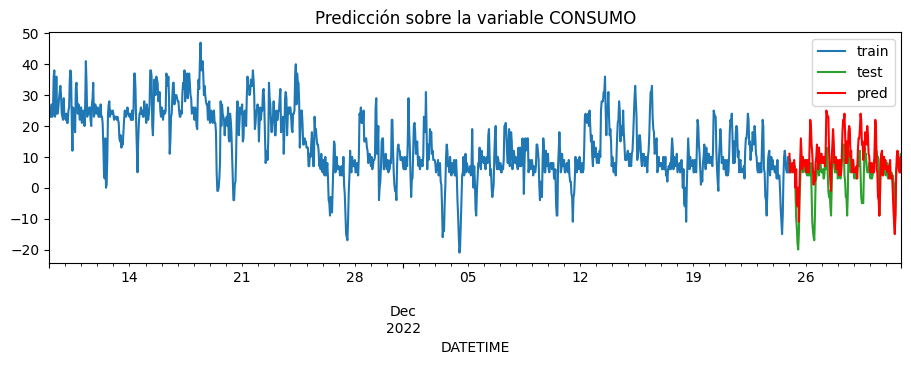

In [43]:
metrics, tiempo = backtesting(baseline, df_consumo_total, train_val_data, test_data)
tabla_comparacion_modelos = guardar_results(f'ForecasterEquivalentDate({params})', tiempo, metrics['MAE'], metrics['MSE'], metrics['RMSE'], tabla_comparacion_modelos)

Una vez tenemos un baseline, probemos a modelar la serie mediante un tipo de modelo estadístico muy usado para series temporales: ARIMA y sus variantes.

### 5.2. ARIMA (AutoRegressive Integrated Moving Average)

#### 5.2.1. Análisis exploratorio de la serie

Antes de aplicar ARIMA, es necesario:

1. **Verificar Estacionariedad**

Observando la gráfica de la serie temporal, parece que la media y la varianza permanencen más o menos constantes, lo cuál es un indicador de estacionaridad. Pero para asegurarnos, aplicaremos la prueba de **Dickey Fuller aumentada** y la de **Kwiatkowski-Phillips-Schmidt-Shin (KPSS)**.

In [44]:
def test_estacionariedad(df): ## tengo dudas sobre si esto se aplica sobre todo el conjunto o solo sobre el de train
    print(f'Test estacionariedad para la serie de la variable {variable}')
    print('--------------------------------------------------------------')
    adfuller_result = adfuller(df[variable])
    kpss_result = kpss(df[variable])
    print(f'ADF Statistic: {adfuller_result[0]}, p-value: {adfuller_result[1]}')
    print(f'KPSS Statistic: {kpss_result[0]}, p-value: {kpss_result[1]}')

In [45]:
test_estacionariedad(train_val_data)

Test estacionariedad para la serie de la variable CONSUMO
--------------------------------------------------------------
ADF Statistic: -1.8919799696896331, p-value: 0.3358433411894684
KPSS Statistic: 2.9675361963387226, p-value: 0.01


Notar que para la prueba DF el p-value > 0.05 y para la de KPSS el p-value < 0.05, luego se considera que la serie es estacionarias y es necesario diferenciar.

In [46]:
train_data_diff_1 = train_val_data[['PK_CLIENTE', variable]].diff().dropna()

In [47]:
test_estacionariedad(train_data_diff_1)

Test estacionariedad para la serie de la variable CONSUMO
--------------------------------------------------------------
ADF Statistic: -15.441817746548875, p-value: 2.8584628855114465e-28
KPSS Statistic: 0.021958131501291903, p-value: 0.1


Ahora los valores de los p-values si que están en el umbral que deben estar. Por lo tanto:

In [48]:
d = 1

Pintemos las gráficas de las series diferenciadas:

<Axes: title={'center': 'Diferenciación de orden 1 de la serie de la variable CONSUMO'}, xlabel='DATETIME'>

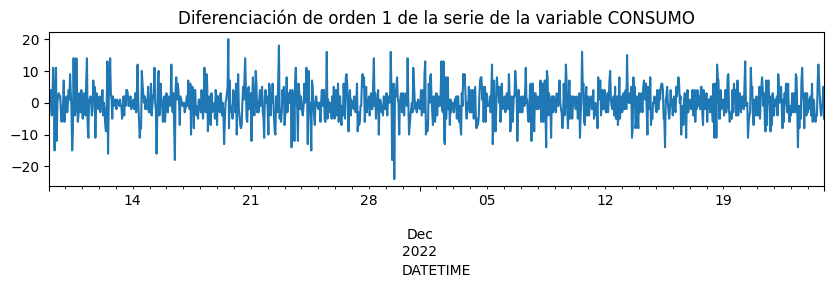

In [49]:
fig, ax = plt.subplots(figsize=(10, 2))
train_data_diff_1[variable].plot(ax=ax, title=f'Diferenciación de orden 1 de la serie de la variable {variable}')

Los análisis posteriores debemos realizarlos con la serie diferenciada.

2. **Análisis de autocorrelación**

La ACF ayuda a identificar el valor de $q$ (lags en la parte de media móvil), mientras que la PACF ayuda a identificar el valor de $p$ (lags en la parte autorregresiva).

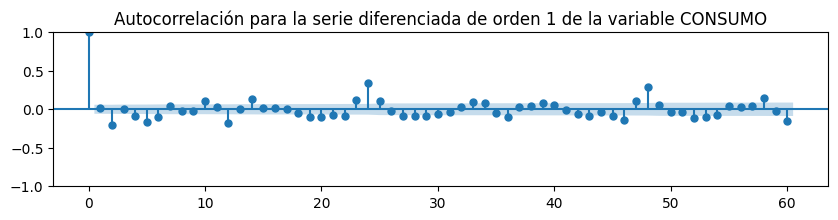

In [50]:
fig, ax = plt.subplots(figsize=(10, 2))

plot_acf(train_data_diff_1[variable], ax=ax, lags=60)
ax.set_title(f'Autocorrelación para la serie diferenciada de orden 1 de la variable {variable}')
plt.show()

In [51]:
q = 1

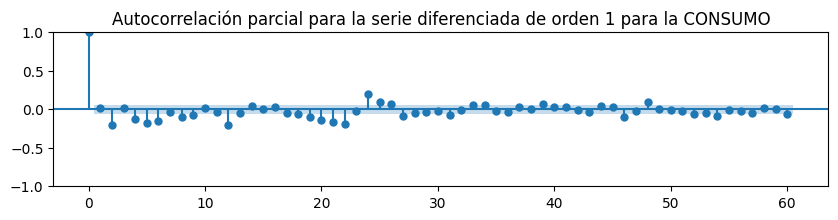

In [52]:
fig, ax = plt.subplots(figsize=(10, 2))
plot_pacf(train_data_diff_1[variable], ax=ax, lags=60, method='ywm')
ax.set_title(f'Autocorrelación parcial para la serie diferenciada de orden 1 para la {variable}')
plt.show()

In [53]:
p = 1

#### 5.2.2. Creación y entrenamiento del modelo

In [54]:
def modelo_ARIMA(train_data, test_data, p, d, q):
    inicio = time.time()
    params = {
        'order': (p, d, q)
    }
    modelo = ARIMA(**params)
    model_fit = modelo.fit(train_data[variable])
    predicciones = model_fit.predict(n_periods=len(test_data[variable]))
    forecast = model_fit.predict(n_periods=len(test_data[variable]), return_conf_int=False)

    metrics = all_metrics(predicciones, test_data)
    print(f"Métricas de error: {metrics}")

    fig, ax = plt.subplots(figsize=(11, 3))
    train_data[variable].plot(ax=ax, label='train', color = '#1f77b4')
    test_data[variable].plot(ax=ax, label='test', color = '#2ca02c')
    predicciones.plot(ax=ax, label='pred', color = '#FF0000')
    ax.set_title(f'Predicciones con ARIMA para la variable {variable}')
    ax.legend()

    fin = time.time()
    tiempo = fin-inicio
    print(tiempo)
    return params, metrics, tiempo

Métricas de error: {'MAE': 5.401354447521918, 'MSE': 49.17149379579406, 'RMSE': 7.012238857582795}
1.7413129806518555


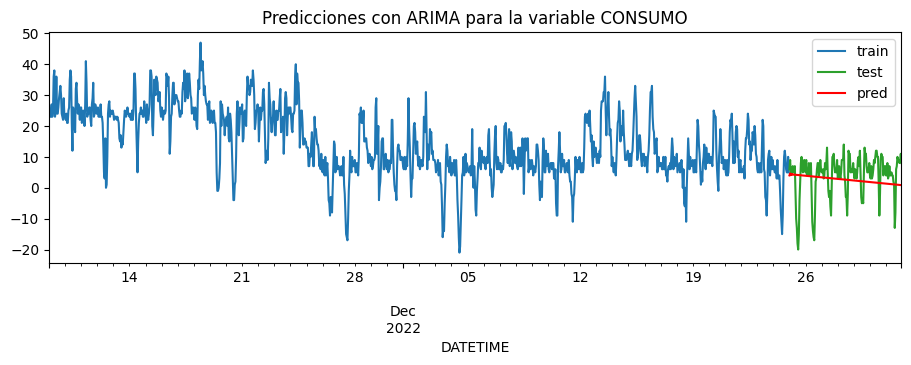

In [55]:
params, metrics, tiempo = modelo_ARIMA(train_val_data, test_data, p, d, q)
tabla_comparacion_modelos = guardar_results(f'ARIMA({params})', tiempo, metrics['MAE'], metrics['MSE'], metrics['RMSE'], tabla_comparacion_modelos)

Los resultados con modelos ARIMA son muy malos, peores incluso que los obtenidos con el modelo baseline. Notar que las predicciones son casi planas. Puede que se deba a la existente estacionalidad de los datos. Deberemos modelar también la componente estacional con SARIMA.

### 5.3. SARIMA (Seasonal ARIMA)

SARIMA es una extensión de ARIMA que incluye componentes estacionales. Ideal para datos que muestran estacionalidad, como el consumo eléctrico que hemos visto que sigue un ciclo diario.

#### 5.3.1. Análisis exploratorio de la serie

Como hemos detectado que nuestras series tienen estacionalidad, será útil realizar una descomposición estacional de series temporales (STL), es decir, descomponer la serie temporal en sus componentes fundamentales para un análisis más detallado:

- La tendencia
- La estacionalidad
- Los residuos

Este análisis puede revelar patrones ocultos y ayudar a identificar la estacionalidad, además de los valores óptimos de los parámetros $P$, $D$, $Q$ y $s$ (y puede llevarse a cabo de manera aditiva o multiplicativa).

In [56]:
def descomposicion_estacional(df):
    res_decompose = seasonal_decompose(df[variable], model='additive', extrapolate_trend='freq')

    fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(14, 7))
    res_decompose.observed.plot(ax=axs[0, 0])
    axs[0, 0].set_title('Serie')
    res_decompose.trend.plot(ax=axs[0, 1])
    axs[0, 1].set_title('Tendencia')
    res_decompose.seasonal.plot(ax=axs[1, 0])
    axs[1, 0].set_title('Estacionalidad')
    res_decompose.resid.plot(ax=axs[1, 1])
    axs[1, 1].set_title('Residuos')
    fig.suptitle(f'Descomposición estacional de la serie para la variable {variable}', fontsize=14)
    fig.tight_layout()

    return res_decompose

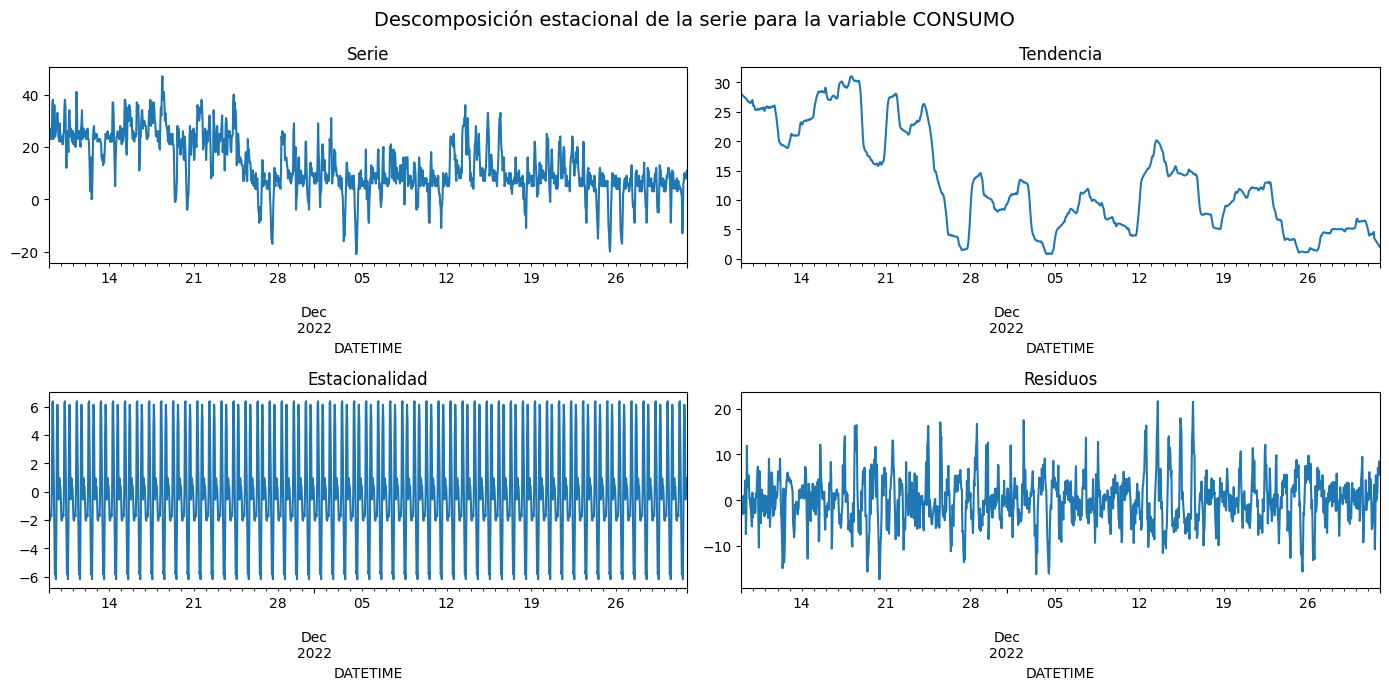

In [57]:
descomposicion_estacional(df_consumo_total)

- La estacionalidad muestra un patrón muy claro con ciclos regulares de 24 horas (lags) en las tres series temporales. De aquí se sigue el valor de s.

- En las gráficas de tendencia se puede apreciar una tendencia decreciente.

In [58]:
s = 24

#### 5.3.2. Creación y entrenamiento del modelo ForecasterSarimax

In [59]:
P, D, Q = 1,1,1

Probaremos a aplicar el modelo SARIMA con las dos librerías que lo tienen tanto skforecast como pmdarima.

In [60]:
params = {
        'order': (p, d, q),
        'seasonal_order': (P, D, Q, s),
        'enforce_stationarity' : False
    }
forecaster_skforecast = ForecasterSarimax(regressor=Sarimax(**params)) #maxiter=200
#forecaster_pmdarima = ForecasterSarimax(regressor=ARIMA(**params))

In [61]:
metrics, tiempo = backtesting(forecaster_skforecast, df_consumo_total, train_val_data, test_data, grafica = False)
tabla_comparacion_modelos = guardar_results(f'ForecasterSarimax(regressor=Sarimax({params})', tiempo, metrics['MAE'], metrics['MSE'], metrics['RMSE'], tabla_comparacion_modelos)

  0%|          | 0/7 [00:00<?, ?it/s]

Tiempo de ejecución: 33.63067817687988
Métricas de error: {'MAE': 3.7279469235024756, 'MSE': 28.1866918893054, 'RMSE': 5.3091140399604715}
--------------------------------


##### Con reentrenamiento

In [62]:
metrics, tiempo = backtesting(forecaster_skforecast, df_consumo_total, train_val_data, test_data, grafica = False, refit = True)
tabla_comparacion_modelos = guardar_results(f'ForecasterSarimax(regressor=Sarimax({params})', tiempo, metrics['MAE'], metrics['MSE'], metrics['RMSE'], tabla_comparacion_modelos, refit = 'Si')

  0%|          | 0/7 [00:00<?, ?it/s]

Tiempo de ejecución: 190.2614026069641
Métricas de error: {'MAE': 3.6546200711478627, 'MSE': 27.705563763565266, 'RMSE': 5.263607485704577}
--------------------------------


##### Con variables exógenas

In [63]:
metrics, tiempo = backtesting(forecaster_skforecast, df_consumo_total, train_val_data, test_data, exog_cols = exog_cols)
tabla_comparacion_modelos = guardar_results(f'ForecasterSarimax(regressor=Sarimax({params})', tiempo, metrics['MAE'], metrics['MSE'], metrics['RMSE'], tabla_comparacion_modelos, var_exog = 'Si')

KeyboardInterrupt: 

##### Con reentrenamiento y variables exógenas

In [ ]:
metrics, tiempo = backtesting(forecaster_skforecast, df_consumo_total, train_val_data, test_data, grafica = False, refit = True, exog_cols = exog_cols)
tabla_comparacion_modelos = guardar_results(f'ForecasterSarimax(regressor=Sarimax({params})', tiempo, metrics['MAE'], metrics['MSE'], metrics['RMSE'], tabla_comparacion_modelos, refit = 'Si', var_exog = 'Si')

### 5.4. Modelo autoregresivo recursivo con Gradient Boosting Machines (GBM): LGBMRegressor

#### 5.4.1. Creación y entrenamiento del modelo

Se entrena un modelo autorregresivo recursivo (ForecasterAutoreg) con gradient boosting LGBMRegressor como regresor. El parámetro lags es la ventana temporal que se utiliza para predecir la demanda de la hora siguiente, iteremos sobre sus valores. El resto de hiperparámetros del regresor se dejan en sus valores por defecto.

  0%|          | 0/7 [00:00<?, ?it/s]

Tiempo de ejecución: 0.4226696491241455
Métricas de error: {'MAE': 5.2837799645619326, 'MSE': 63.397149604878436, 'RMSE': 7.962232702256223}
--------------------------------


  0%|          | 0/7 [00:00<?, ?it/s]

Tiempo de ejecución: 0.5032444000244141
Métricas de error: {'MAE': 2.97268244704497, 'MSE': 18.49044257554442, 'RMSE': 4.300051461964661}
--------------------------------


  0%|          | 0/7 [00:00<?, ?it/s]

Tiempo de ejecución: 1.0003077983856201
Métricas de error: {'MAE': 3.8762282069286136, 'MSE': 29.050131483242847, 'RMSE': 5.389817388673094}
--------------------------------


  0%|          | 0/7 [00:00<?, ?it/s]

Tiempo de ejecución: 1.565873622894287
Métricas de error: {'MAE': 5.042450362088469, 'MSE': 52.438107808539804, 'RMSE': 7.2414161466207565}
--------------------------------


  0%|          | 0/7 [00:00<?, ?it/s]

Tiempo de ejecución: 0.6207683086395264
Métricas de error: {'MAE': 4.441117534583516, 'MSE': 41.31543109359964, 'RMSE': 6.427708074702805}
--------------------------------


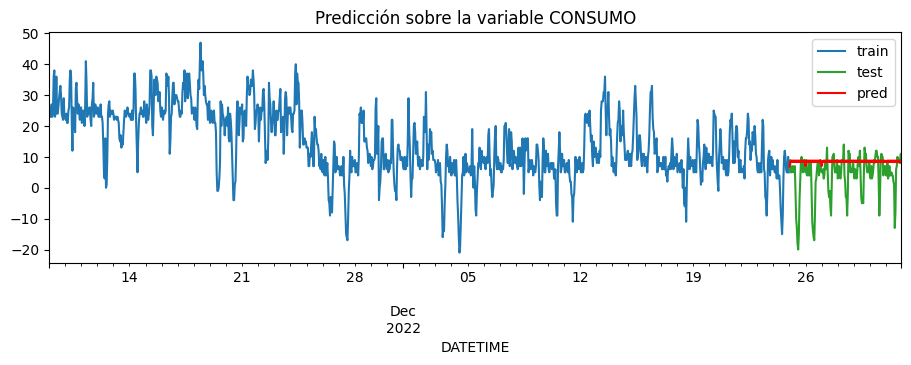

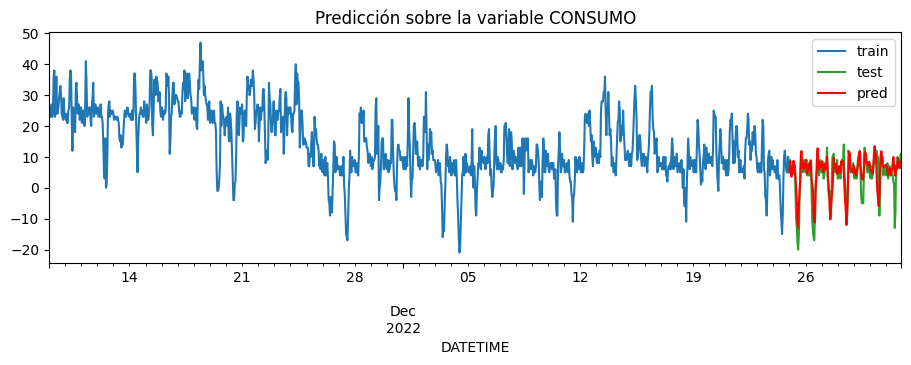

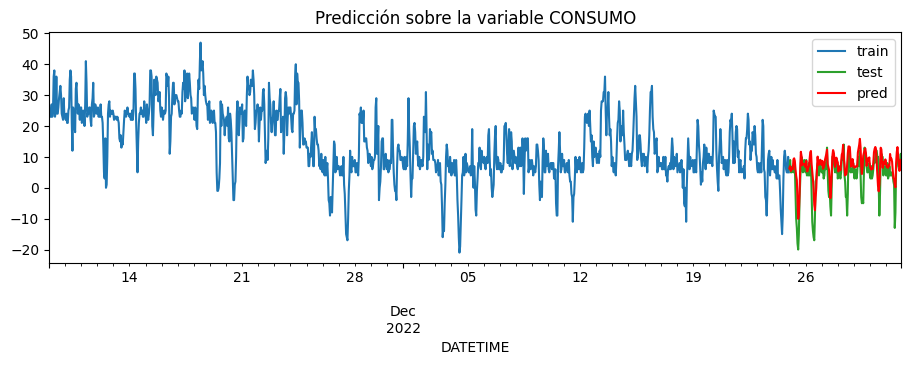

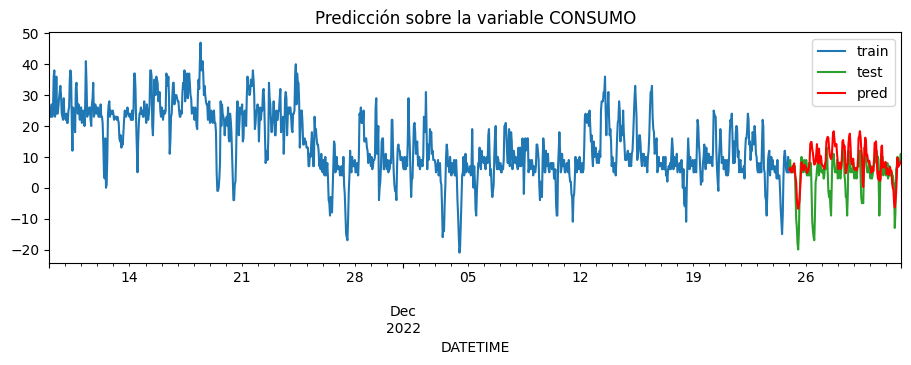

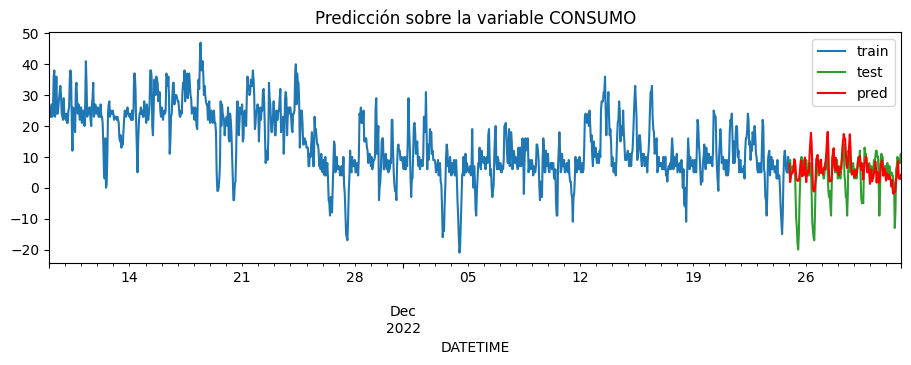

In [64]:
for i in [1, 24, 168, 720, 1008]:
  forecaster_ar_base = ForecasterAutoreg(regressor = LGBMRegressor(random_state=1, verbose = -1, verbose_eval = False), lags = i)
  metrics, tiempo = backtesting(forecaster_ar_base, df_consumo_total, train_val_data, test_data)
  tabla_comparacion_modelos = guardar_results(f'ForecasterAutoreg(regressor = {forecaster_ar_base.regressor}), lags = {forecaster_ar_base.lags}', tiempo, metrics['MAE'], metrics['MSE'], metrics['RMSE'], tabla_comparacion_modelos)

##### Con reentrenamiento

In [65]:
for i in [1, 24, 168, 720, 1008]:
  forecaster_ar_base = ForecasterAutoreg(regressor = LGBMRegressor(random_state=1, verbose = -1, verbose_eval = False), lags = i)
  metrics, tiempo = backtesting(forecaster_ar_base, df_consumo_total, train_val_data, test_data, grafica = False, refit = True)
  #tabla_comparacion_modelos = guardar_results(f'ForecasterAutoreg(regressor = {forecaster_ar_base.regressor}), lags = {forecaster_ar_base.lags}', tiempo, metrics['MAE'], metrics['MSE'], metrics['RMSE'], tabla_comparacion_modelos)

  0%|          | 0/7 [00:00<?, ?it/s]

Tiempo de ejecución: 6.823158502578735
Métricas de error: {'MAE': 5.220338199005644, 'MSE': 62.558987947183766, 'RMSE': 7.909423995916755}
--------------------------------


  0%|          | 0/7 [00:00<?, ?it/s]

Tiempo de ejecución: 1.2932195663452148
Métricas de error: {'MAE': 3.1301985505705545, 'MSE': 19.740102392107854, 'RMSE': 4.442983501219406}
--------------------------------


  0%|          | 0/7 [00:00<?, ?it/s]

Tiempo de ejecución: 5.8924336433410645
Métricas de error: {'MAE': 3.3449376694204482, 'MSE': 25.415844365454518, 'RMSE': 5.041412933439842}
--------------------------------


  0%|          | 0/7 [00:00<?, ?it/s]

Tiempo de ejecución: 7.508796215057373
Métricas de error: {'MAE': 3.2261582058211653, 'MSE': 25.126843245575227, 'RMSE': 5.012668276035751}
--------------------------------


  0%|          | 0/7 [00:00<?, ?it/s]

Tiempo de ejecución: 2.999782085418701
Métricas de error: {'MAE': 3.8456072111978146, 'MSE': 33.32048760001679, 'RMSE': 5.772390111558365}
--------------------------------


##### Con variables exógenas

In [66]:
for i in [1, 24, 168, 720, 1008]:
  forecaster_ar_base = ForecasterAutoreg(regressor = LGBMRegressor(random_state=1, verbose = -1, verbose_eval = False), lags = i)
  metrics, tiempo = backtesting(forecaster_ar_base, df_consumo_total, train_val_data, test_data, grafica = False, exog_cols = exog_cols)
  #tabla_comparacion_modelos = guardar_results(f'ForecasterAutoreg(regressor = {forecaster_ar_base.regressor}), lags = {forecaster_ar_base.lags}', tiempo, metrics['MAE'], metrics['MSE'], metrics['RMSE'], tabla_comparacion_modelos)

  0%|          | 0/7 [00:00<?, ?it/s]

Tiempo de ejecución: 0.34253787994384766
Métricas de error: {'MAE': 6.717089790506802, 'MSE': 87.60303457953043, 'RMSE': 9.35964927652369}
--------------------------------


  0%|          | 0/7 [00:00<?, ?it/s]

Tiempo de ejecución: 0.6035475730895996
Métricas de error: {'MAE': 3.6729874141622965, 'MSE': 31.654407609039996, 'RMSE': 5.626224987417406}
--------------------------------


  0%|          | 0/7 [00:00<?, ?it/s]

Tiempo de ejecución: 1.3901820182800293
Métricas de error: {'MAE': 4.15404715764174, 'MSE': 32.7292349888571, 'RMSE': 5.7209470360122285}
--------------------------------


  0%|          | 0/7 [00:00<?, ?it/s]

Tiempo de ejecución: 1.7272849082946777
Métricas de error: {'MAE': 4.82071387602491, 'MSE': 48.82783380252323, 'RMSE': 6.987691593260483}
--------------------------------


  0%|          | 0/7 [00:00<?, ?it/s]

Tiempo de ejecución: 0.7666623592376709
Métricas de error: {'MAE': 4.450946981831687, 'MSE': 39.55796513327589, 'RMSE': 6.28951231283284}
--------------------------------


##### Con reentrenamiento y con variables exógenas

  0%|          | 0/7 [00:00<?, ?it/s]

Tiempo de ejecución: 2.1818253993988037
Métricas de error: {'MAE': 5.9284539172622175, 'MSE': 69.10965757665677, 'RMSE': 8.313221852967523}
--------------------------------


  0%|          | 0/7 [00:00<?, ?it/s]

Tiempo de ejecución: 1.6914806365966797
Métricas de error: {'MAE': 3.207320034214427, 'MSE': 22.848724518711407, 'RMSE': 4.780033945351373}
--------------------------------


  0%|          | 0/7 [00:00<?, ?it/s]

Tiempo de ejecución: 4.4145896434783936
Métricas de error: {'MAE': 3.2184996553200174, 'MSE': 21.323325450467593, 'RMSE': 4.617718641327944}
--------------------------------


  0%|          | 0/7 [00:00<?, ?it/s]

Tiempo de ejecución: 9.860146522521973
Métricas de error: {'MAE': 3.1605585611804576, 'MSE': 24.810705110060024, 'RMSE': 4.981034542146844}
--------------------------------


  0%|          | 0/7 [00:00<?, ?it/s]

Tiempo de ejecución: 3.609896659851074
Métricas de error: {'MAE': 3.6385846400059667, 'MSE': 31.744463947643688, 'RMSE': 5.634222568167119}
--------------------------------


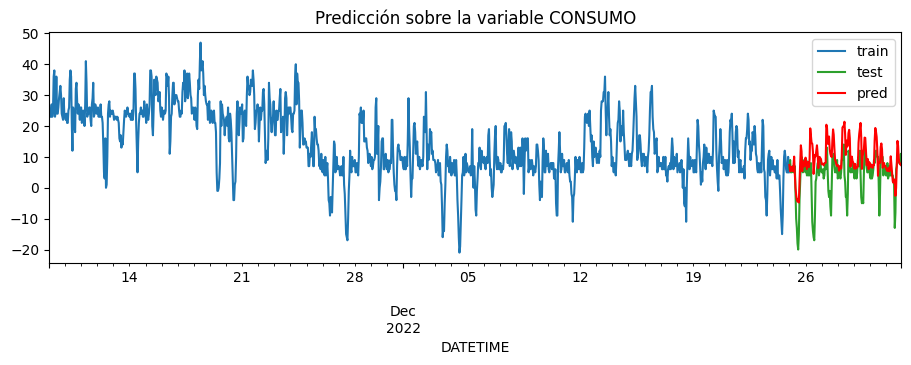

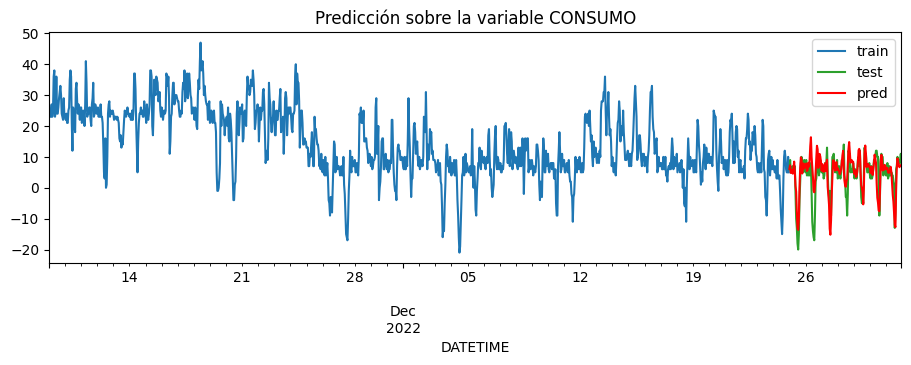

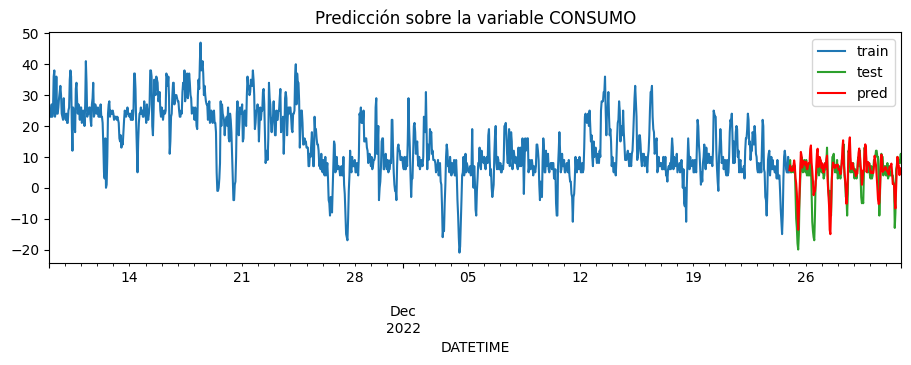

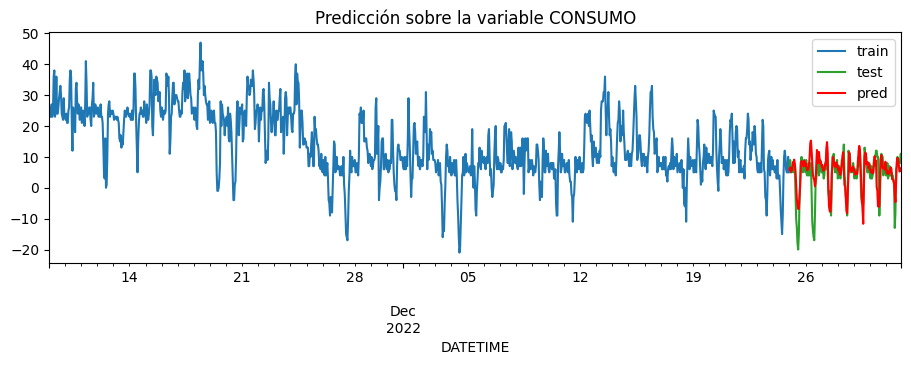

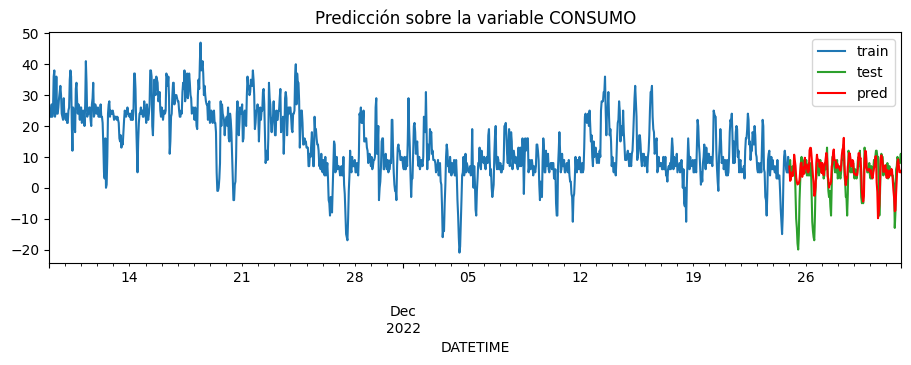

In [67]:
for i in [1, 24, 168, 720, 1008]:
  forecaster_ar_base = ForecasterAutoreg(regressor = LGBMRegressor(random_state=1, verbose = -1, verbose_eval = False), lags = i)
  metrics, tiempo = backtesting(forecaster_ar_base, df_consumo_total, train_val_data, test_data, refit = True, exog_cols = exog_cols)
  #tabla_comparacion_modelos = guardar_results(f'ForecasterAutoreg(regressor = {forecaster_ar_base.regressor}), lags = {forecaster_ar_base.lags}', tiempo, metrics['MAE'], metrics['MSE'], metrics['RMSE'], tabla_comparacion_modelos)

Notar que el error disminuye usando más lags para la predicción y reentrenando los datos según se van haciendo las predicciones.

#### 5.4.5. Explicabilidad

In [68]:
forecaster_1 = ForecasterAutoreg(regressor = LGBMRegressor(random_state=1, verbose = -1, verbose_eval = False, exog_cols = exog_cols), lags = 1)
forecaster_24 = ForecasterAutoreg(regressor = LGBMRegressor(random_state=1, verbose = -1, verbose_eval = False, exog_cols = exog_cols), lags = 24)
forecaster_1008 = ForecasterAutoreg(regressor = LGBMRegressor(random_state=1, verbose = -1, verbose_eval = False, exog_cols = exog_cols), lags = 1008)

In [69]:
#importancia de los predictores
feature_importances = importancia_features(forecaster_1, df_consumo_total, train_val_data)
feature_importances

,feature,%_importance
0,lag_1,13.20
1,HUMEDAD_RELATIVA,10.20
2,VIENTO_AND_RACHA_MAX,7.67
3,VIENTO_VELOCIDAD,6.50
4,TEMPERATURA,5.23
5,poly_DIA_SEMANA_coseno__HORA_coseno,5.17
6,HORA_coseno,5.13
7,poly_DIA_SEMANA_coseno__HORA_seno,5.07
8,poly_HORA_coseno__ORTO_coseno,5.07
9,poly_DIA_SEMANA_seno__HORA_coseno,4.67


In [70]:
#importancia de los predictores
feature_importances = importancia_features(forecaster_24, df_consumo_total, train_val_data)
feature_importances

,feature,%_importance
0,lag_1,6.27
1,lag_24,4.67
2,HUMEDAD_RELATIVA,4.53
3,lag_23,3.73
4,lag_3,3.70
5,VIENTO_AND_RACHA_MAX,3.30
6,lag_18,3.13
7,lag_4,3.10
8,poly_DIA_SEMANA_coseno__HORA_coseno,3.03
9,lag_2,2.93


In [71]:
#importancia de los predictores
feature_importances = importancia_features(forecaster_1008, df_consumo_total, train_val_data)
feature_importances

,feature,%_importance
0,lag_150,2.42
1,lag_540,2.42
2,lag_816,2.42
3,lag_930,2.08
4,lag_603,1.73
5,lag_335,1.73
6,lag_576,1.73
7,lag_176,1.73
8,lag_195,1.73
9,lag_216,1.73


### 5.5. Árboles de Decisión y Random Forest

#### 5.5.1. Creación y entrenamiento del modelo

  0%|          | 0/7 [00:00<?, ?it/s]

Tiempo de ejecución: 20.571947813034058
Métricas de error: {'MAE': 2.841190476190476, 'MSE': 18.262755952380953, 'RMSE': 4.273494583169722}
--------------------------------


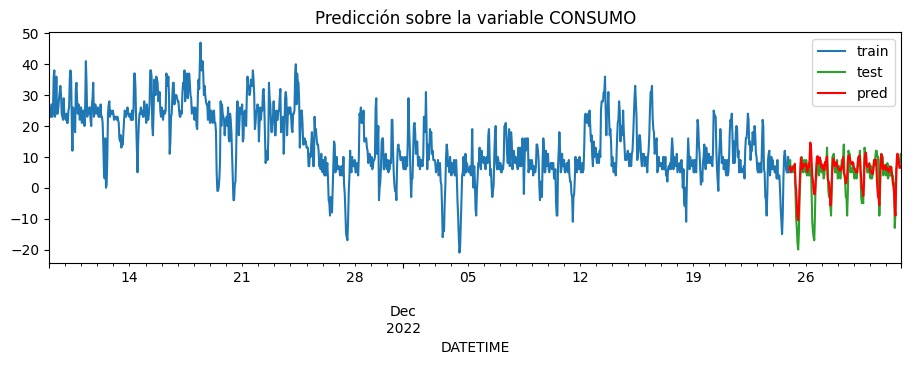

In [72]:
forecaster_ar_rf = ForecasterAutoreg(regressor = RandomForestRegressor(random_state=123),lags = 24)
metrics, tiempo = backtesting(forecaster_ar_rf, df_consumo_total, train_val_data, test_data, refit = True, exog_cols = exog_cols)

  0%|          | 0/7 [00:00<?, ?it/s]

Tiempo de ejecución: 1.2857789993286133
Métricas de error: {'MAE': 5.314035750595455, 'MSE': 63.910830572102356, 'RMSE': 7.994424968195171}
--------------------------------


  0%|          | 0/7 [00:00<?, ?it/s]

Tiempo de ejecución: 3.1019082069396973
Métricas de error: {'MAE': 3.136011904761905, 'MSE': 20.643868452380953, 'RMSE': 4.543552404493751}
--------------------------------


  0%|          | 0/7 [00:00<?, ?it/s]

Tiempo de ejecución: 8.087130546569824
Métricas de error: {'MAE': 4.029702380952381, 'MSE': 33.596739880952384, 'RMSE': 5.796269479669866}
--------------------------------


  0%|          | 0/7 [00:00<?, ?it/s]

Tiempo de ejecución: 12.035370826721191
Métricas de error: {'MAE': 5.522440476190477, 'MSE': 72.60635892857142, 'RMSE': 8.520936505371427}
--------------------------------


  0%|          | 0/7 [00:00<?, ?it/s]

Tiempo de ejecución: 3.3223061561584473
Métricas de error: {'MAE': 5.779107142857144, 'MSE': 70.95157916666668, 'RMSE': 8.423276035288566}
--------------------------------


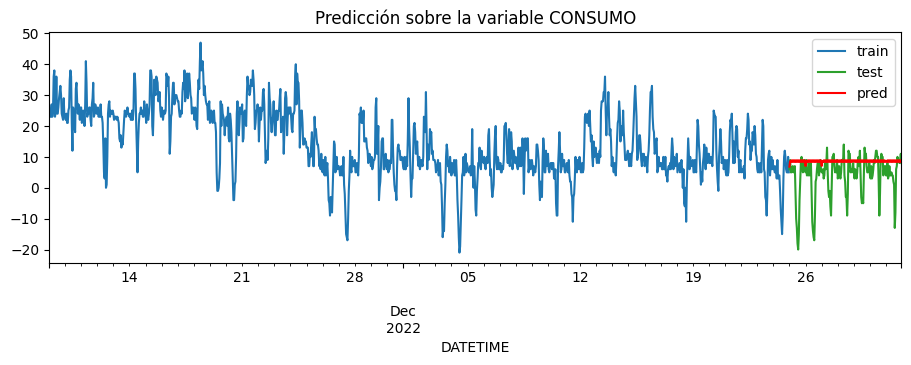

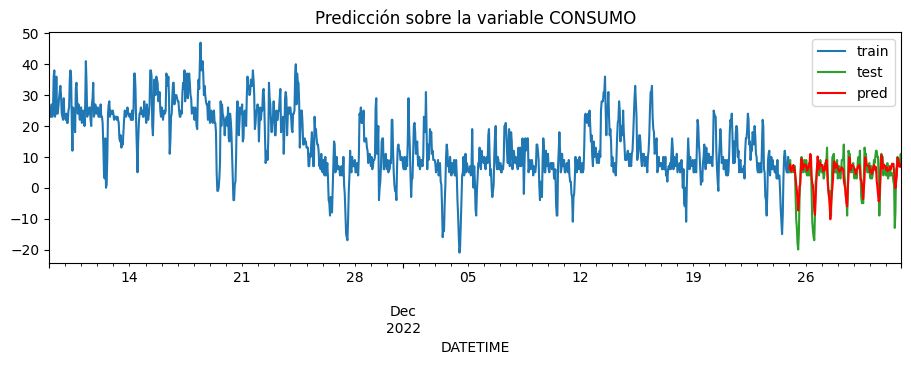

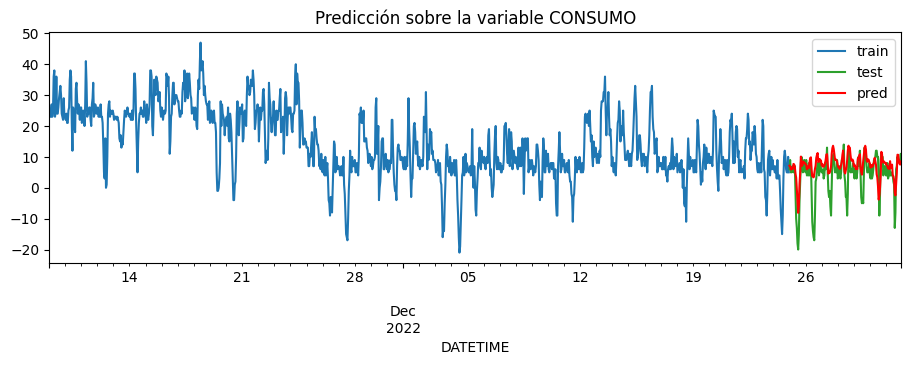

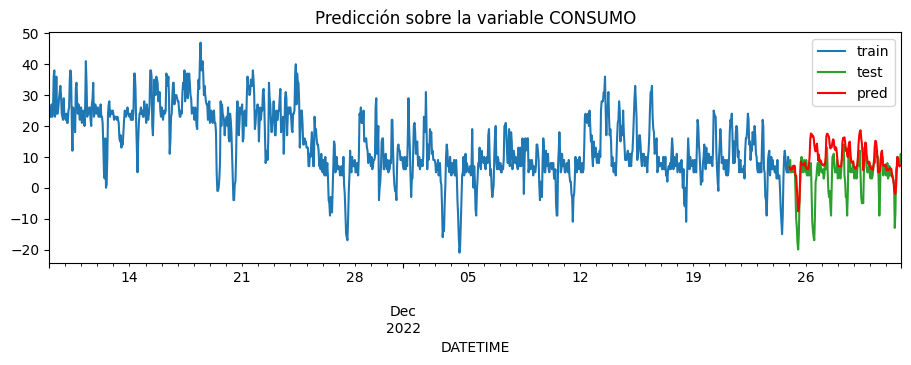

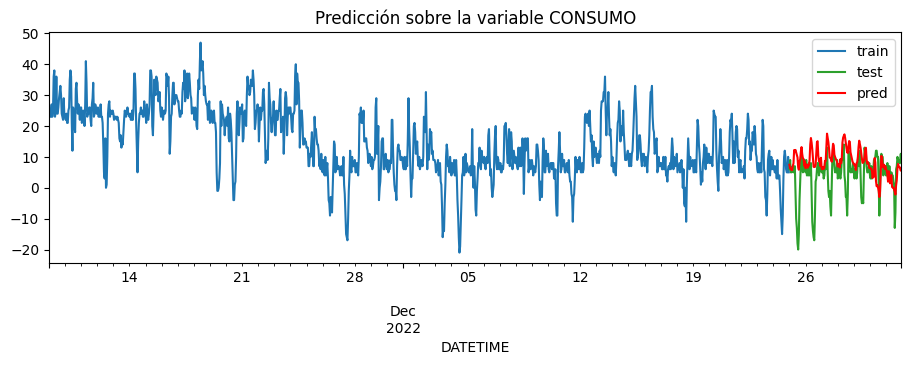

In [73]:
for i in [1, 24, 168, 720, 1008]:
  forecaster_ar_rf = ForecasterAutoreg(regressor = RandomForestRegressor(random_state=123),lags = i)
  metrics, tiempo = backtesting(forecaster_ar_rf, df_consumo_total, train_val_data, test_data)
  tabla_comparacion_modelos = guardar_results(f'ForecasterAutoreg(regressor = {forecaster_ar_rf.regressor}), lags = {forecaster_ar_rf.lags}', tiempo, metrics['MAE'], metrics['MSE'], metrics['RMSE'], tabla_comparacion_modelos)

##### Con reentrenamiento

In [74]:
for i in [1, 24, 168, 720, 1008]:
  forecaster_ar_rf = ForecasterAutoreg(regressor = RandomForestRegressor(random_state=123),lags = i)
  metrics, tiempo = backtesting(forecaster_ar_rf, df_consumo_total, train_val_data, test_data, grafica = False, refit = True)
  #tabla_comparacion_modelos = guardar_results(f'ForecasterAutoreg(regressor = {forecaster_ar_rf.regressor}), lags = {forecaster_ar_rf.lags}', tiempo, metrics['MAE'], metrics['MSE'], metrics['RMSE'], tabla_comparacion_modelos)

  0%|          | 0/7 [00:00<?, ?it/s]

Tiempo de ejecución: 1.9945051670074463
Métricas de error: {'MAE': 5.232008566729879, 'MSE': 62.756487199087545, 'RMSE': 7.92189921667068}
--------------------------------


  0%|          | 0/7 [00:00<?, ?it/s]

Tiempo de ejecución: 11.654049634933472
Métricas de error: {'MAE': 3.065952380952381, 'MSE': 20.320958333333333, 'RMSE': 4.50787736449577}
--------------------------------


  0%|          | 0/7 [00:00<?, ?it/s]

Tiempo de ejecución: 48.39073896408081
Métricas de error: {'MAE': 3.3844047619047615, 'MSE': 26.01591547619048, 'RMSE': 5.100579915675322}
--------------------------------


  0%|          | 0/7 [00:00<?, ?it/s]

Tiempo de ejecución: 79.50926566123962
Métricas de error: {'MAE': 3.906428571428571, 'MSE': 42.71250952380952, 'RMSE': 6.535480818104321}
--------------------------------


  0%|          | 0/7 [00:00<?, ?it/s]

Tiempo de ejecución: 34.39291501045227
Métricas de error: {'MAE': 4.34875, 'MSE': 48.57578511904762, 'RMSE': 6.969633069182883}
--------------------------------


##### Con variables exógenas

In [75]:
for i in [1, 24, 168, 720, 1008]:
  forecaster_ar_rf = ForecasterAutoreg(regressor =  RandomForestRegressor(random_state=123), lags = i)
  metrics, tiempo = backtesting(forecaster_ar_rf, df_consumo_total, train_val_data, test_data, grafica = False, exog_cols = exog_cols)
  #tabla_comparacion_modelos = guardar_results(f'ForecasterAutoreg(regressor = {forecaster_ar_rf.regressor}), lags = {forecaster_ar_rf.lags}', tiempo, metrics['MAE'], metrics['MSE'], metrics['RMSE'], tabla_comparacion_modelos)

  0%|          | 0/7 [00:00<?, ?it/s]

Tiempo de ejecución: 2.6005077362060547
Métricas de error: {'MAE': 6.603988095238096, 'MSE': 96.04945297619048, 'RMSE': 9.800482282836416}
--------------------------------


  0%|          | 0/7 [00:00<?, ?it/s]

Tiempo de ejecución: 4.905075550079346
Métricas de error: {'MAE': 2.949821428571428, 'MSE': 18.685387499999997, 'RMSE': 4.322659771483293}
--------------------------------


  0%|          | 0/7 [00:00<?, ?it/s]

Tiempo de ejecución: 9.854876041412354
Métricas de error: {'MAE': 3.6303571428571426, 'MSE': 26.417941666666668, 'RMSE': 5.139838680996386}
--------------------------------


  0%|          | 0/7 [00:00<?, ?it/s]

Tiempo de ejecución: 12.523900747299194
Métricas de error: {'MAE': 5.521726190476191, 'MSE': 74.20258035714286, 'RMSE': 8.614091963587507}
--------------------------------


  0%|          | 0/7 [00:00<?, ?it/s]

Tiempo de ejecución: 3.3515079021453857
Métricas de error: {'MAE': 5.737976190476191, 'MSE': 69.74311547619047, 'RMSE': 8.351234368414676}
--------------------------------


##### Con reentrenamiento y variables exógenas

  0%|          | 0/7 [00:00<?, ?it/s]

Tiempo de ejecución: 16.586021661758423
Métricas de error: {'MAE': 6.3689285714285715, 'MSE': 92.86079166666667, 'RMSE': 9.636430442164084}
--------------------------------


  0%|          | 0/7 [00:00<?, ?it/s]

Tiempo de ejecución: 25.180120706558228
Métricas de error: {'MAE': 2.841190476190476, 'MSE': 18.262755952380953, 'RMSE': 4.273494583169722}
--------------------------------


  0%|          | 0/7 [00:00<?, ?it/s]

Tiempo de ejecución: 58.20840549468994
Métricas de error: {'MAE': 3.1517261904761904, 'MSE': 22.14194345238095, 'RMSE': 4.705522654539127}
--------------------------------


  0%|          | 0/7 [00:00<?, ?it/s]

Tiempo de ejecución: 111.17221236228943
Métricas de error: {'MAE': 3.7041071428571426, 'MSE': 42.26809940476191, 'RMSE': 6.501392112829522}
--------------------------------


  0%|          | 0/7 [00:00<?, ?it/s]

Tiempo de ejecución: 60.15337300300598
Métricas de error: {'MAE': 4.164404761904761, 'MSE': 46.61364642857143, 'RMSE': 6.827418723688436}
--------------------------------


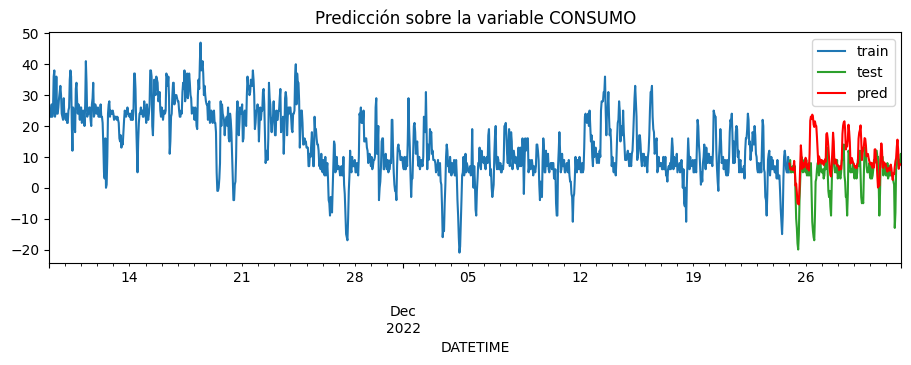

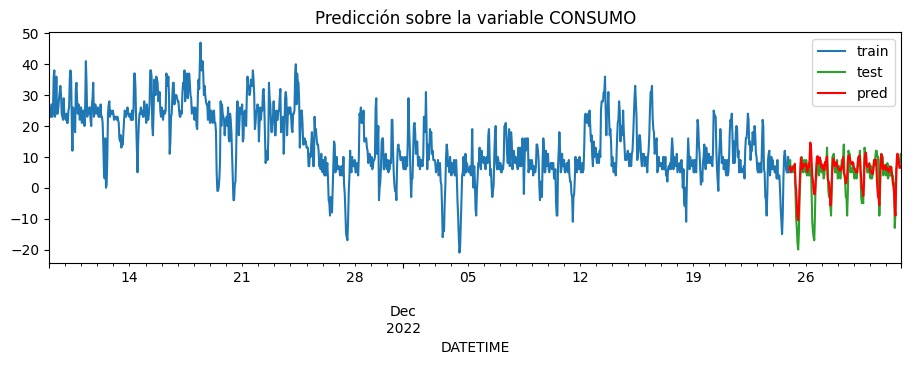

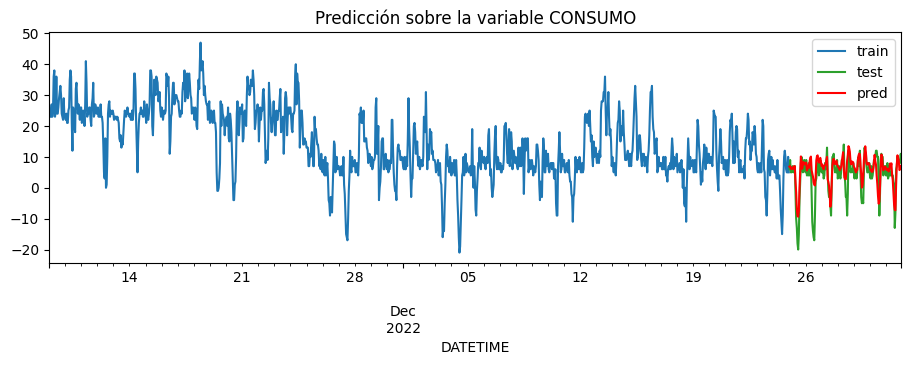

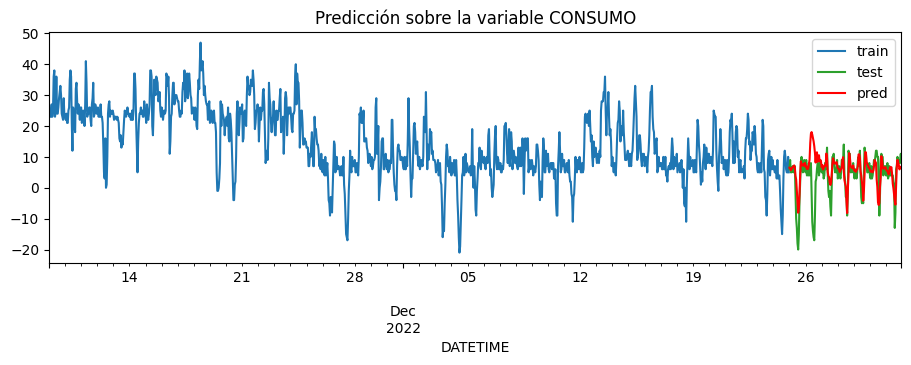

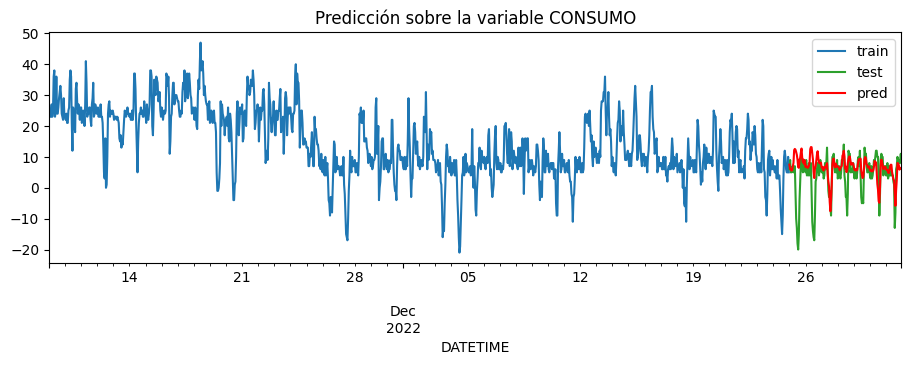

In [76]:
for i in [1, 24, 168, 720, 1008]:
  forecaster_ar_rf = ForecasterAutoreg(regressor = RandomForestRegressor(random_state=123), lags = i)
  metrics, tiempo = backtesting(forecaster_ar_rf, df_consumo_total, train_val_data, test_data, refit = True, exog_cols = exog_cols)
  tabla_comparacion_modelos = guardar_results(f'ForecasterAutoreg(regressor = {forecaster_ar_rf.regressor}), lags = {forecaster_ar_rf.lags}', tiempo, metrics['MAE'], metrics['MSE'], metrics['RMSE'], tabla_comparacion_modelos, refit = 'Si', var_exog = 'Si')

### 5.7. Prophet

INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpoeqe611y/7gmlp0s7.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpoeqe611y/5y5um3g2.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=71209', 'data', 'file=/tmp/tmpoeqe611y/7gmlp0s7.json', 'init=/tmp/tmpoeqe611y/5y5um3g2.json', 'output', 'file=/tmp/tmpoeqe611y/prophet_model4o6x29wd/prophet_model-20240709125450.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
12:54:50 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
12:54:51 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


Métricas de error: MAE: 6.2014048084786175, MSE: 69.52362586020796, RMSE: 8.338082864796197
2.2648251056671143


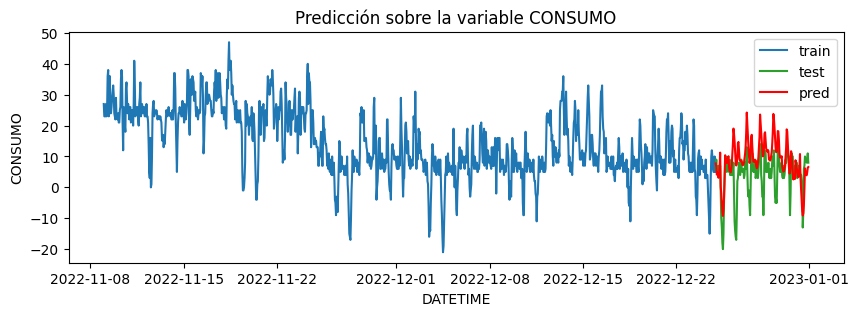

In [77]:
prophet_train = train_val_data[[variable] + exog_cols].reset_index().rename(columns={'DATETIME': 'ds', variable: 'y'})
prophet_test = test_data[[variable] + exog_cols].reset_index().rename(columns={'DATETIME': 'ds', variable: 'y'})

inicio = time.time()
m = Prophet(weekly_seasonality=True, daily_seasonality=True, seasonality_mode='additive', changepoint_prior_scale=0.1,
    seasonality_prior_scale=10.0)

for i in exog_cols:
    m.add_regressor(i)
m.add_country_holidays(country_name='ES')  # Usa el país correspondiente a tus datos
m.fit(prophet_train)

future = m.make_future_dataframe(periods=len(prophet_test), freq='H', include_history=True)
for col in exog_cols:
    future[col] = pd.concat([train_val_data[col], test_data[col]]).reset_index(drop=True)

forecast = m.predict(future)
forecast_test = forecast[-len(prophet_test):]
fin = time.time()
tiempo = fin - inicio
mae = mean_absolute_error(prophet_test['y'], forecast_test['yhat'])
mse = mean_squared_error(prophet_test['y'], forecast_test['yhat'])
rmse = mse ** 0.5
print(f'Métricas de error: MAE: {mae}, MSE: {mse}, RMSE: {rmse}')
print(tiempo)

plt.figure(figsize=(10, 3))
plt.plot(prophet_train['ds'], prophet_train['y'], label='train', color = '#1f77b4')
plt.plot(prophet_test['ds'], prophet_test['y'], label='test', color = '#2ca02c')
plt.plot(forecast_test['ds'], forecast_test['yhat'], label='pred', color = '#FF0000')
plt.xlabel('DATETIME')
plt.ylabel(variable)
plt.title(f'Predicción sobre la variable {variable}')
plt.legend()
plt.show()

## 6. Evaluación de los modelos

In [78]:
tabla_comparacion_modelos = tabla_comparacion_modelos.sort_values(by='MAE', ascending = True)
tabla_comparacion_modelos.to_csv(f'/content/drive/MyDrive/TFM/tabla_comparacion_modelos_CLIENTE_{variable}.csv')

In [79]:
tabla_comparacion_modelos.sort_values(by='MAE', ascending = True)

,Modelo,Tiempo de ejecución,Variables exógenas,refit,MAE,MSE,RMSE
15,"ForecasterAutoreg(regressor = RandomForestRegressor(random_state=123)), lags = [ 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24]",25.180121,Si,Si,2.8,18.3,4.3
5,"ForecasterAutoreg(regressor = LGBMRegressor(random_state=1, verbose=-1, verbose_eval=False)), lags = [ 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24]",0.503244,No,No,3.0,18.5,4.3
10,"ForecasterAutoreg(regressor = RandomForestRegressor(random_state=123)), lags = [ 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24]",3.101908,No,No,3.1,20.6,4.5
16,"ForecasterAutoreg(regressor = RandomForestRegressor(random_state=123)), lags = [ 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18\n 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36\n 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51 52 53 54\n 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72\n 73 74 75 76 77 78 79 80 81 82 83 84 85 86 87 88 89 90\n 91 92 93 94 95 96 97 98 99 100 101 102 103 104 105 106 107 108\n 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125 126\n 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143 144\n 145 146 147 148 149 150 151 152 153 154 155 156 157 158 159 160 161 162\n 163 164 165 166 167 168]",58.208405,Si,Si,3.2,22.1,4.7
2,"ForecasterSarimax(regressor=Sarimax({'order': (1, 1, 1), 'seasonal_order': (1, 1, 1, 24), 'enforce_stationarity': False})",33.630678,No,No,3.7,28.2,5.3
3,"ForecasterSarimax(regressor=Sarimax({'order': (1, 1, 1), 'seasonal_order': (1, 1, 1, 24), 'enforce_stationarity': False})",190.261403,No,Si,3.7,27.7,5.3
17,"ForecasterAutoreg(regressor = RandomForestRegressor(random_state=123)), lags = [ 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18\n 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36\n 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51 52 53 54\n 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72\n 73 74 75 76 77 78 79 80 81 82 83 84 85 86 87 88 89 90\n 91 92 93 94 95 96 97 98 99 100 101 102 103 104 105 106 107 108\n 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125 126\n 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143 144\n 145 146 147 148 149 150 151 152 153 154 155 156 157 158 159 160 161 162\n 163 164 165 166 167 168 169 170 171 172 173 174 175 176 177 178 179 180\n 181 182 183 184 185 186 187 188 189 190 191 192 193 194 195 196 197 198\n 199 200 201 202 203 204 205 206 207 208 209 210 211 212 213 214 215 216\n 217 218 219 220 221 222 223 224 225 226 227 228 229 230 231 232 233 234\n 235 236 237 238 239 240 241 242 243 244 245 246 247 248 249 250 251 252\n 253 254 255 256 257 258 259 260 261 262 263 264 265 266 267 268 269 270\n 271 272 273 274 275 276 277 278 279 280 281 282 283 284 285 286 287 288\n 289 290 291 292 293 294 295 296 297 298 299 300 301 302 303 304 305 306\n 307 308 309 310 311 312 313 314 315 316 317 318 319 320 321 322 323 324\n 325 326 327 328 329 330 331 332 333 334 335 336 337 338 339 340 341 342\n 343 344 345 346 347 348 349 350 351 352 353 354 355 356 357 358 359 360\n 361 362 363 364 365 366 367 368 369 370 371 372 373 374 375 376 377 378\n 379 380 381 382 383 384 385 386 387 388 389 390 391 392 393 394 395 396\n 397 398 399 400 401 402 403 404 405 406 407 408 409 410 411 412 413 414\n 415 416 417 418 419 420 421 422 423 424 425 426 427 428 429 430 431 432\n 433 434 435 436 437 438 439 440 441 442 443 444 445 446 447 448 449 450\n 451 452 453 454 455 456 457 458 459 460 461 462 463 464 465 466 467 468\n 469 470 471 472 473 474 475 476 477 478 479 480 481 482 483 484 485 486\n 487 488 489 490 491 492 493 494 495 496 497 498 499 500 501 502 503 504\n 505 506 507 508 509 510 511 512 513 514 515 516 517 518 519 520 521 522\n 523 524 525 526 527 528 529 530 531 532 533 534 535 536 537 538 539 540\n 541 542 543 544 545 546 547 548 549 550 551 552 553 554 555 556 557 558\n 559 560 561 562 563 564 565 566 567 568 569 570 571 572 573 574 575 576\n 577 578 579 580 581 582 

Guardamos las predicciones del mejor modelo para poder utilizarlas.

  0%|          | 0/7 [00:00<?, ?it/s]

Tiempo de ejecución: 20.689332246780396
Métricas de error: {'MAE': 2.841190476190476, 'MSE': 18.262755952380953, 'RMSE': 4.273494583169722}
--------------------------------


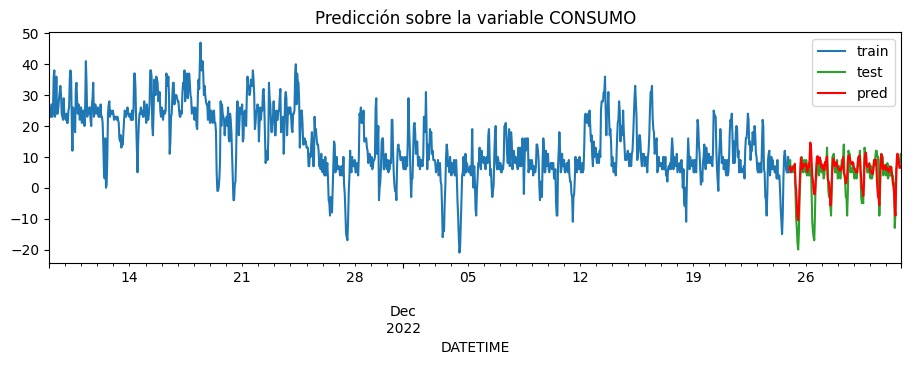

In [82]:
mejor_modelo = ForecasterAutoreg(regressor = RandomForestRegressor(random_state=123), lags = 24)
metrics, tiempo, predictions = backtesting(mejor_modelo, df_consumo_total, train_val_data, test_data, refit = True, exog_cols = exog_cols)

In [83]:
predictions.to_csv('/content/drive/MyDrive/TFM/predictions_CLIENTE_CONSUMO.csv', index=True)

## 7. Comparación con las predicciones de la serie temporal de CONSUMO medio de un cliente para la provincia de Girona

In [84]:
predicciones_CLIENTE = pd.read_csv('/content/drive/MyDrive/TFM/predictions_CLIENTE_CONSUMO.csv', index_col=0).rename(columns = {'pred': 'predicciones CLIENTE'})

In [85]:
predicciones_PROVINCIA = pd.read_csv('/content/drive/MyDrive/TFM/predictions_PROVINCIA_CONSUMO.csv', index_col=0).rename(columns = {'pred': 'predicciones media de PROVINCIA'})

In [86]:
predicciones_CLIENTE.index = pd.to_datetime(predicciones_CLIENTE.index)
predicciones_PROVINCIA.index = pd.to_datetime(predicciones_PROVINCIA.index)

In [87]:
metrics = all_metrics(predicciones_PROVINCIA, test_data)
print(f"Métricas de error: {metrics}")

Métricas de error: {'MAE': 6.230438927614928, 'MSE': 50.7263208666714, 'RMSE': 7.1222412811327445}


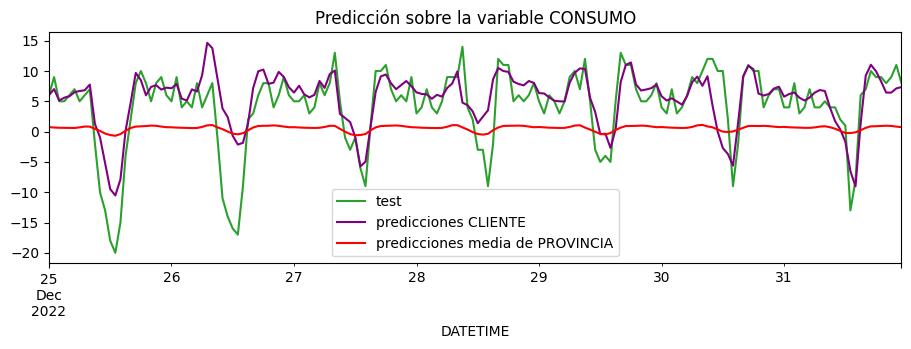

In [88]:
fig, ax = plt.subplots(figsize=(11, 3))
#train_val_data[variable].plot(ax=ax, label='train', color = '#1f77b4')
# color para el de validación '#ff7f0e'
test_data[variable].plot(ax=ax, label='test', color = '#2ca02c')
predicciones_CLIENTE.plot(ax=ax, label='predicciones CLIENTE', color = '#800080')
predicciones_PROVINCIA.plot(ax=ax, label='predicciones media de PROVINCIA', color = '#FF0000')
ax.set_title(f'Predicción sobre la variable {variable}')
ax.legend()